<a href="https://colab.research.google.com/github/alejandrazuleta1/analisis-multivariado-emg/blob/main/Copia_de_An%C3%A1lisis_Multivariado_EMG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TRATAMIENTO DE SEÑALES III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

*Alejandra Zuleta Gónzalez, Santiago Patiño Guerrero y Natalia Pérez Puentes*

*2021-2*

**Procedimiento para la Extracción de Características**


1. Se tiene una señal de entrada $y(t) \in \mathcal{R}^{20000\times 1}$
2. Para la señal original: Calculamos $D_1=13$ características las cuales son a) RMSE b) MAE c) 5 Potencias máximas d) 5 Frecuencias a Pmax, e) Num de cruces por cero. Dando lugar a un vector de características $x_1  \in \mathcal{R}^{13\times 1}$
3. Luego Adicionaremos a estas $D_1$ características, otro conjunto a partir de descomposiciones Wavelet. En el cual para la señal original se realizará un proceso de $M$ descomposiciones utilizando la $dwt$
4. Para cada nivel de descomposición $M$, se calcularán $D_2$ características, las cuales son: Entropía – variance, standard deviation, Mean, Median, 25th percentile value, 75th percentile value, Root Mean
Square value; square of the average of the squared amplitude values, The mean of the derivative
– Zero crossing rate, i.e. the number of times a signal crosses y = 0
– Mean crossing rate, i.e. the number of times a signal crosses y = mean(y). Dando lugar a $D_2 = 12$ características por cada nivel de descomposición.

Finalmente el vector completo de características para la señal $y(t)$, será:

$x = [x_1,x_{des_1},\cdots,x_{des_M}]^{\top} \in \mathcal{R}^{(D_1*(M*D_2))\times 1}$  

La matriz completa será:
$\mathbf{X} = [x_1^\top,x_2^\top,\cdots,x_N^\top] \in \mathcal{R}^{N\times (D_1*(M*D_2))}$

In [ ]:
!pip install antropy

In [ ]:
#librerías
from scipy.stats import entropy
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import pywt
import antropy as ant

In [ ]:
#Funciones utilizadas
def cruces_por_cero(signal):
  cruces=0
  for cont,valor in enumerate(signal):
    if cont!=len(signal)-1:
      if signal[cont]*signal[cont+1]<=0:
        cruces+=1
    else:
      if signal[cont]*signal[cont-1]<0:
        cruces+=1
  return cruces




def featureExtractionEMG(sampleSignal):
  # Esta función toma como argumento de entrada una señal EMG de 20000 muestras y retorna 13 caracteristicas relacionadas a la señal
  # a. Removemos el nivel DC
  nivelDC = np.mean(sampleSignal)
  sampleSignal = sampleSignal-nivelDC
  # b. Normalicemos las señales para que tengan amplitud unitaria
  maxSignal = np.abs(np.max(sampleSignal))
  sampleSignal = sampleSignal/maxSignal
  # Realicemos el análisis STFT
  f, t, Zxx = signal.stft(sampleSignal, fs, nperseg=600)

  rms = np.sqrt((np.sum(sampleSignal)**2)/len(sampleSignal))
  mae = np.sum(np.abs(sampleSignal))/len(sampleSignal)
  # En la matriz Zxx se tiene una matriz de #defrecs * #times
# Zxx[i,j], sería el espectro en la frecuencia[i] y el tiempo [j]
  absZxx = np.abs(Zxx)
  Pmax_Zxx = np.max(absZxx,axis=1) # dB

  Pmax_Zxx_dB = 20*np.log10(Pmax_Zxx)
  idx = np.argsort(Pmax_Zxx_dB)
  maximos = Pmax_Zxx_dB[idx]
  auxPot = maximos[-5:]
  frecuencias = f[idx]
  fPmax_Zxx = frecuencias[-5:]
  feature_set = np.zeros((13,))
  feature_set[0] = rms
  feature_set[1] = mae
  feature_set[2:7] = auxPot
  feature_set[7:12] = fPmax_Zxx
  feature_set[12] = cruces_por_cero(sampleSignal)
  return feature_set




def first_features(data_EMG):
  L_Signal, Classes, Ntrials = np.shape(data_EMG)
  D = 13 # número de características

  X = np.zeros((Classes*Ntrials,D))
  t = np.zeros((Classes*Ntrials,1))
  pos = 0
  for clase in range(0,Classes):
    for n in range(0,Ntrials):
      sampleSignal = data_EMG[:,clase,n]
      # Luego le extraemos las D características a cada señal del experimento
      x_n = featureExtractionEMG(sampleSignal)
      X[pos, :] = x_n
      t[pos] = clase
      pos = pos + 1
  return X , t




def calculate_entropy(list_values):
  #list_values = np.squeeze(list_values)
  entropyVal =ant.perm_entropy(list_values, normalize=True)
  return entropyVal




def calculate_statistics(list_values):
  n5 = np.nanpercentile(list_values, 5)
  n25 = np.nanpercentile(list_values, 25)
  n75 = np.nanpercentile(list_values, 75)
  n95 = np.nanpercentile(list_values, 95)
  median = np.nanpercentile(list_values, 50)
  mean = np.nanmean(list_values)
  std = np.nanstd(list_values)
  var = np.nanvar(list_values)
  rms = np.nanmean(np.sqrt(list_values**2))
  return [n5, n25, n75, n95, median, mean, std, var, rms]




def calculate_crossings(list_values):
  zero_crossing_indices = np.where(np.diff(np.signbit(list_values)))[0]
  no_zero_crossings = len(zero_crossing_indices)
  mean_crossing_indices = np.where(np.diff(np.signbit(list_values-np.nanmean(list_values))))[0]
  no_mean_crossings = len(mean_crossing_indices)
  return [no_zero_crossings, no_mean_crossings]




def get_features(list_values):
  entropy = calculate_entropy(list_values)
  crossings = calculate_crossings(list_values)
  statistics = calculate_statistics(list_values)
  return [entropy] + crossings + statistics



def second_features(data_selec,nDesc):
  waveletname = 'sym'+str(nDesc)
  L_Signal, Classes, Ntrials = np.shape(data_selec)

  X_w = np.zeros((Classes*Ntrials,nDesc+1,12))
  pos = 0
  for clase in range(0,Classes):
    for n in range(0,Ntrials):
      data = data_selec[:,clase,n]
      for ii in range(nDesc):
          (data, coeff_d) = pywt.dwt(data, waveletname)
          
          if ii==0:
            x_wavelet = get_features(coeff_d)   
            X_w[pos, ii, :] = x_wavelet
          
          x_d = get_features(data)
          X_w[pos, ii+1, :] = x_d
            
      pos = pos + 1

  feature_set = np.zeros((Classes*Ntrials,12*(nDesc+1))) 
  ban=0
  for t in range(Classes*Ntrials):
    vector=np.zeros(12*(nDesc+1))
    for th in range(nDesc+1):
      vector_temp=np.zeros(12)
      vector_temp = X_w[t][th]
      vector[ban:12+ban] = vector_temp
      ban+=12
    feature_set[t,:]=vector
    ban=0
  return feature_set




def final(nDes,var1,var2,etq):
  X_final=np.zeros((1134,12*(nDes+1)+13+1))
  for i in range (len(var1)):
    X_final[i,:13] = var1[i]
    X_final[i,13:-1] = var2[i]
    X_final[i,-1] = etq[i]
  return X_final



def organize_dataFrame(X_final):
  Nombres_1 = ['RMS','MAE','P1','P2','P3','P4','P5','F1','F2','F3','F4','F5','Num Cruces Por Cero']
  Nombres_2 = ['Entropy','n5','n25','n75','n95','Median','Mean','std','var','RMS','no_zero_cross','no_mean_cross']
  dataFrame = pd.DataFrame(data = X_final[:,:13], columns= Nombres_1)
  m=13
  for n in range(nDes+1):
    if n==0:
      for i in range(12):
        valor = Nombres_2[i] +'_coeff_d'
        dataFrame[valor] = X_final[:,m]
        m+=1
    else:
      for i in range(12):
        valor = Nombres_2[i] +'_' +str(n)
        dataFrame[valor] = X_final[:,m]
        m+=1
  dataFrame['Tipo Mov'] = X_final[:,-1]
  return dataFrame


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta = '/content/drive/Shareddrives/Señales III/EMG_SIGNAL/'
data1 = loadmat(ruta+'S1_20140620T021349.mat')
data2 = loadmat(ruta+'S2_20140623T203911.mat')
data3 = loadmat(ruta+'S3_20140623T192807.mat')

In [ ]:
data_EMG_1 = data1['data_EMG']
data_EMG_2 = data2['data_EMG']
data_EMG_3 = data3['data_EMG']

fs = 4e3
Ts = 1./fs

In [ ]:
x_1, t_1 = first_features(data_EMG_1)
x_2, t_2 = first_features(data_EMG_2)
x_3, t_3 = first_features(data_EMG_3)

In [ ]:
nDes=3 # AQUI SE COLOCA EL NÚMERO DE NIVELES QUE SE QUIERE
x_sec1 = second_features(data_EMG_1,nDes)
x_sec2 = second_features(data_EMG_2,nDes)
x_sec3 = second_features(data_EMG_3,nDes)

X_final_1 = final(nDes,x_1,x_sec1,t_1)
X_final_2 = final(nDes,x_2,x_sec2,t_2)
X_final_3 = final(nDes,x_3,x_sec3,t_3)

In [ ]:
dataFrame_1=organize_dataFrame(X_final_1)
dataFrame_2=organize_dataFrame(X_final_2)
dataFrame_3=organize_dataFrame(X_final_3)

In [ ]:
dataFrame_1

,RMS,MAE,P1,P2,P3,P4,P5,F1,F2,F3,F4,F5,Num Cruces Por Cero,Entropy_coeff_d,n5_coeff_d,n25_coeff_d,n75_coeff_d,n95_coeff_d,Median_coeff_d,Mean_coeff_d,std_coeff_d,var_coeff_d,RMS_coeff_d,no_zero_cross_coeff_d,no_mean_cross_coeff_d,Entropy_1,n5_1,n25_1,n75_1,n95_1,Median_1,Mean_1,std_1,var_1,RMS_1,no_zero_cross_1,no_mean_cross_1,Entropy_2,n5_2,n25_2,n75_2,n95_2,Median_2,Mean_2,std_2,var_2,RMS_2,no_zero_cross_2,no_mean_cross_2,Entropy_3,n5_3,n25_3,n75_3,n95_3,Median_3,Mean_3,std_3,var_3,RMS_3,no_zero_cross_3,no_mean_cross_3,Tipo Mov
0,9.640368e-16,0.124181,-24.510315,-24.113682,-22.973331,-22.668456,-20.580252,73.333333,60.000000,106.666667,46.666667,53.333333,1578.0,0.994690,4831.0,4827.0,-0.000717,-0.000280,0.000277,0.000695,2.778707e-06,-1.637815e-07,0.000435,1.891241e-07,0.000340,0.833429,1234.0,1498.0,-0.018500,-0.000989,0.014121,0.028526,0.006467,0.006290,0.014988,0.000225,0.012098,0.956647,1094.0,1318.0,-0.025633,-0.001313,0.019929,0.039586,0.009289,0.008897,0.021052,0.000443,0.017041,0.982297,722.0,916.0,-0.034203,-0.000619,0.027091,0.053578,0.013156,0.012589,0.027839,0.000775,0.022956,0.0
1,7.222425e-17,0.140894,-22.066990,-21.769165,-21.027955,-20.872663,-20.447376,106.666667,53.333333,86.666667,60.000000,46.666667,1272.0,0.982031,4508.0,4504.0,-0.001183,-0.000382,0.000387,0.001202,4.244089e-07,-1.523531e-06,0.000765,5.848703e-07,0.000540,0.797486,1202.0,1236.0,-0.055978,-0.012071,0.024935,0.065201,0.006128,0.006028,0.036322,0.001319,0.026880,0.928927,1122.0,1166.0,-0.079364,-0.017075,0.035328,0.093082,0.008739,0.008526,0.051071,0.002608,0.037869,0.969842,894.0,918.0,-0.106166,-0.024972,0.048720,0.126408,0.012477,0.012070,0.068590,0.004705,0.051696,0.0
2,3.768222e-16,0.137592,-22.633787,-22.579174,-21.904142,-21.901437,-21.119429,100.000000,60.000000,53.333333,73.333333,80.000000,1217.0,0.977296,4435.0,4427.0,-0.001401,-0.000435,0.000449,0.001374,9.332355e-06,-3.723296e-06,0.000878,7.700504e-07,0.000623,0.789564,1179.0,1191.0,-0.065243,-0.019354,0.028609,0.081929,0.005356,0.005442,0.044367,0.001968,0.033129,0.916243,1123.0,1123.0,-0.091282,-0.027233,0.040243,0.114762,0.007682,0.007703,0.062419,0.003896,0.046719,0.971090,925.0,945.0,-0.124376,-0.038187,0.056164,0.155983,0.010968,0.010878,0.084199,0.007090,0.063634,0.0
3,8.729714e-16,0.159535,-21.146537,-21.044106,-20.848960,-20.630571,-20.237451,60.000000,46.666667,120.000000,93.333333,73.333333,1251.0,0.972576,4295.0,4289.0,-0.001518,-0.000468,0.000493,0.001525,7.938772e-06,4.118074e-06,0.000932,8.692039e-07,0.000674,0.782939,1241.0,1227.0,-0.076608,-0.023084,0.032957,0.085266,0.004023,0.004629,0.049208,0.002421,0.037141,0.917996,1165.0,1163.0,-0.107935,-0.033138,0.046394,0.120227,0.005689,0.006567,0.069244,0.004795,0.052311,0.970630,965.0,949.0,-0.142349,-0.046153,0.065054,0.165014,0.007772,0.009340,0.093430,0.008729,0.071114,0.0
4,7.662051e-16,0.178562,-19.884666,-19.147033,-18.817477,-18.761468,-18.557749,46.666667,80.000000,106.666667,86.666667,93.333333,1282.0,0.968781,4293.0,4291.0,-0.001536,-0.000502,0.000505,0.001518,9.650660e-06,-8.060235e-07,0.000942,8.881684e-07,0.000689,0.783728,1266.0,1266.0,-0.078984,-0.025725,0.032806,0.087618,0.005117,0.004083,0.050064,0.002506,0.038300,0.914143,1180.0,1176.0,-0.111129,-0.036495,0.046187,0.124038,0.007708,0.005815,0.070482,0.004968,0.054027,0.977551,970.0,980.0,-0.149421,-0.048455,0.063363,0.167033,0.010821,0.008342,0.095281,0.009078,0.073305,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,5.514165e-15,0.315701,-19.789814,-18.026123,-14.557632,-10.500420,-9.683625,100.000000,33.333333,40.000000,53.333333,46.666667,773.0,0.997684,4919.0,4929.0,-0.000589,-0.000240,0.000240,0.000589,-6.867701e-06,-2.251135e-06,0.000360,1.293600e-07,0.000286,0.798937,745.0,757.0,-0.041654,-0.027358,0.000971,0.013575,-0.012408,-0.013

In [ ]:
features=dataFrame_1.columns


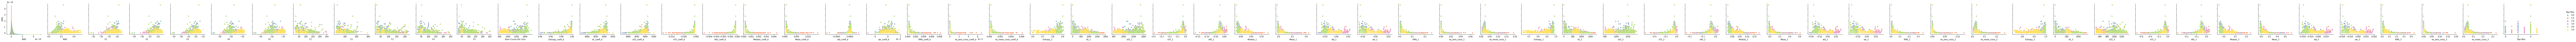

In [ ]:
import seaborn as sns
plot0 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[0], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))


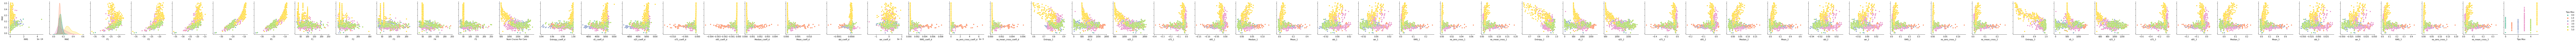

In [ ]:
plot1 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[1], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot2 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[2], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot3 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[3], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot4 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[4], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot5 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[5], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot6 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[6], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot7 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[7], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot8 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[8], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot9 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[9], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot10 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[10], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot11 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[11], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot12 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[12], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot13 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[13], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot14 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[14], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot15 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[15], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot16 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[16], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot17 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[17], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot18 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[18], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot19 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[19], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot20 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[20], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot21 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[21], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot22 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[22], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot23 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[23], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot24 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[24], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot25 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[25], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot26 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[26], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot27 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[27], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot28 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[28], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot29 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[29], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot30 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[30], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot31 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[31], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot32 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[32], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot33 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[33], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot34 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[34], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot35 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[35], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot36 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[36], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot37 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[37], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot38 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[38], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot39 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[39], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot40 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[40], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot41 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[41], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot42 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[42], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot43 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[43], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot44 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[44], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot45 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[45], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot46 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[46], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot47 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[47], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot48 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[48], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot49 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[49], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot50 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[50], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot51 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[51], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot52 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[52], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot53 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[53], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot54 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[54], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot55 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[55], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot56 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[56], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot57 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[57], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot58 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[58], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot59 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[59], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot60 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[60], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))

In [ ]:
plot61 = sns.pairplot(dataFrame_1, x_vars=features, y_vars=features[61], hue="Tipo Mov", height=3, palette = sns.color_palette("Set2",6))